# RNN Variants

The first sub-assignment is to compare performance on the classification task across Recurrent
Network Variants. Specifically compare LSTM and Basic RNN models. You are free to choose
your own state size for the recurrent network, however please use the same state size for both
RNN variants.
Also compare a single layer LSTM implementation to a multi-layer LSTM implementation.

### Import necessary libraries

In [37]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, Bidirectional, Input, concatenate, BatchNormalization, Layer, Conv1D, MaxPooling1D, Flatten, Concatenate
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

!pip install langdetect
from langdetect import detect, DetectorFactory, LangDetectException

from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Load the training data

In [38]:
# Define the path to the data directory
data_dir = './data'

# List all files in the data directory
data_files = os.listdir(data_dir)

# Load the training data (assuming it's a CSV file)
training_data_path = os.path.join(data_dir, 'train.csv')
training_data = pd.read_csv(training_data_path)

# Display the first few rows of the training data
print(training_data.head())

      Artist                     Song Genre Language  \
0  12 stones            world so cold  Rock       en   
1  12 stones                   broken  Rock       en   
2  12 stones             3 leaf loser  Rock       en   
3  12 stones  anthem for the underdog  Rock       en   
4  12 stones               adrenaline  Rock       en   

                                              Lyrics  
0  It starts with pain, followed by hate\nFueled ...  
1  Freedom!\nAlone again again alone\nPatiently w...  
2  Biting the hand that feeds you, lying to the v...  
3  You say you know just who I am\nBut you can't ...  
4  My heart is beating faster can't control these...  


### Data Exploration

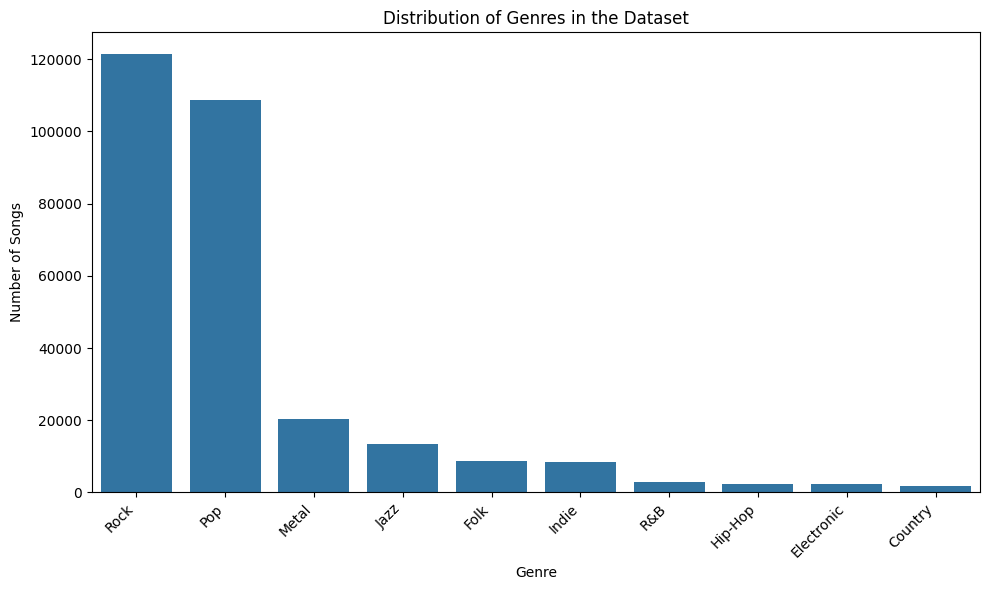

In [9]:
# Count the occurrences of each genre
genre_counts = training_data['Genre'].value_counts()

# Create a bar plot of the genre distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Distribution of Genres in the Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

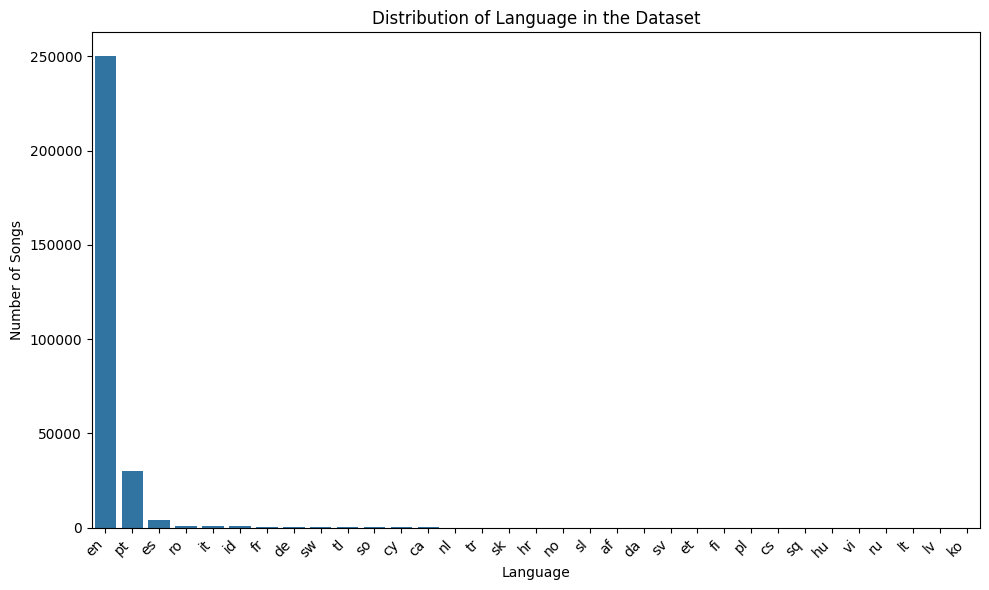

In [11]:
# Assuming 'training_data' DataFrame is already loaded as in the provided code
# Count the occurrences of each genre
genre_counts = training_data['Language'].value_counts()

# Create a bar plot of the genre distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xlabel('Language')
plt.ylabel('Number of Songs')
plt.title('Distribution of Language in the Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [41]:
unique_artists = training_data['Artist'].nunique()
unique_artists

11152

In [60]:
# prompt: Print total number of songs

print(len(training_data))

290183


In [59]:
# Number of songs per artist
songs_per_artist = training_data['Artist'].value_counts()
top_5_artists = songs_per_artist.head(5)
top_5_artists

,count
Artist,
elvis presley,1611
chris brown,1239
elvis costello,923
ella fitzgerald,874
the rolling stones,820


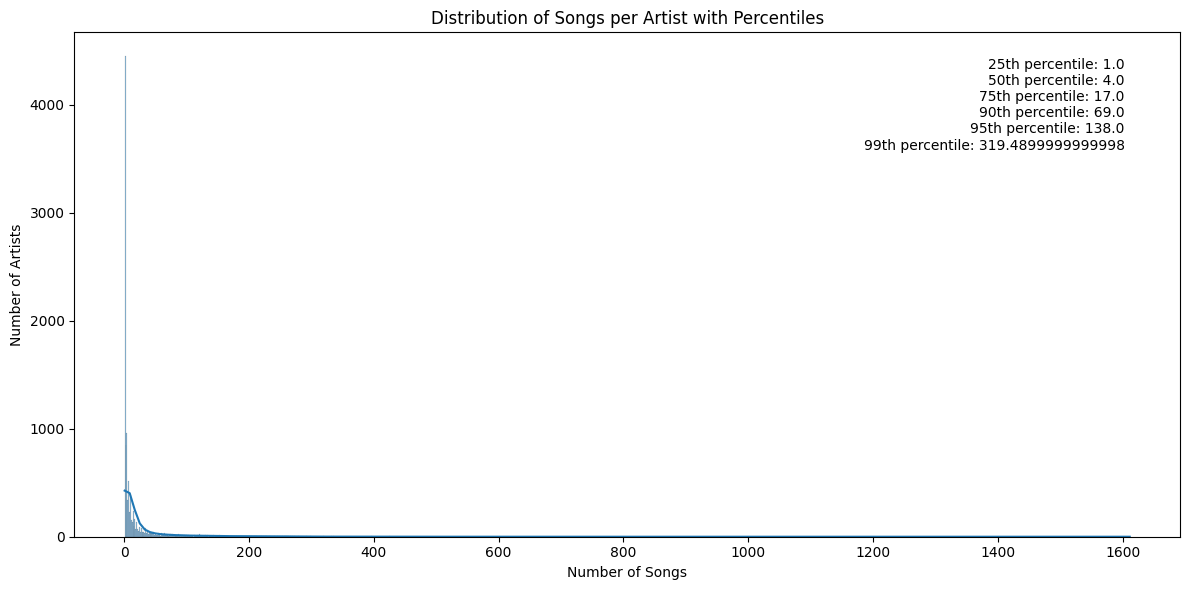

In [56]:
# Assuming 'songs_per_artist' Series is already calculated as in the provided code
plt.figure(figsize=(12, 6))
sns.histplot(songs_per_artist, kde=True)  # Use seaborn's histplot for better visualization

# Calculate and display percentiles
percentiles = np.percentile(songs_per_artist, [25, 50, 75, 90, 95, 99])
percentile_text = "\n".join([f"{p:.0f}th percentile: {v}" for p, v in zip([25, 50, 75, 90, 95, 99], percentiles)])
plt.text(0.95, 0.95, percentile_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right')


plt.xlabel('Number of Songs')
plt.ylabel('Number of Artists')
plt.title('Distribution of Songs per Artist with Percentiles')
plt.tight_layout()
plt.show()

### Preprocess Data

In [61]:
# Calculate the 90th percentile of songs per artist
percentile_90 = np.percentile(songs_per_artist, 90)

# Filter out artists below the 90th percentile
filtered_artists = songs_per_artist[songs_per_artist >= percentile_90].index

# Create a new DataFrame with only the top artists
filtered_training_data = training_data[training_data['Artist'].isin(filtered_artists)]

print(f"Original DataFrame shape: {training_data.shape}")
print(f"Filtered DataFrame shape: {filtered_training_data.shape}")

Original DataFrame shape: (290183, 5)
Filtered DataFrame shape: (199830, 5)


<Axes: xlabel='Genre'>

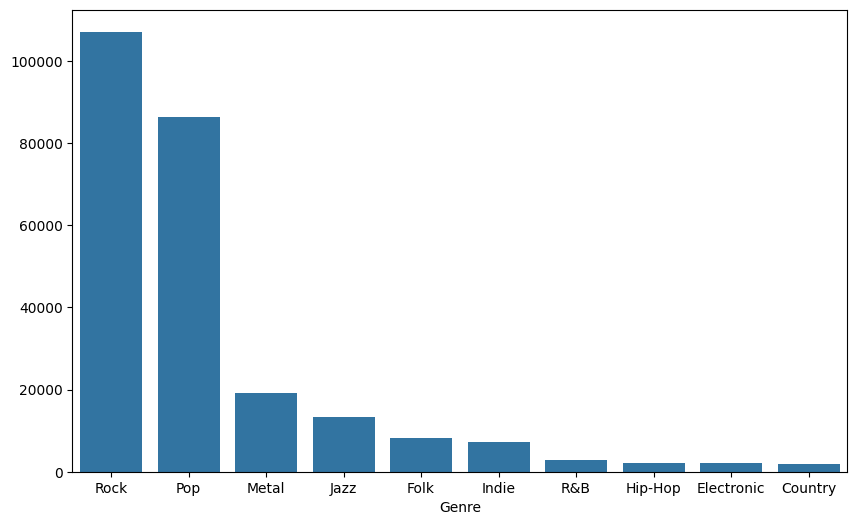

In [108]:
# Remove non-English lyrics
en_training_data = training_data[training_data['Language'] == 'en']

# Plot distribution of data
en_genre_counts = en_training_data['Genre'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=en_genre_counts.index, y=en_genre_counts.values)

In [109]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    # Lowercase
    text = text.lower()
    # Remove stop words
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    text = ' '.join(filtered_words)
    return text

cleaned_en_training_data = en_training_data.copy()
cleaned_en_training_data['Lyrics'] = en_training_data['Lyrics'].apply(clean_text)
cleaned_en_training_data.head()

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,starts pain followed hate fueled endless quest...
1,12 stones,broken,Rock,en,freedom alone alone patiently waiting phone ho...
2,12 stones,3 leaf loser,Rock,en,biting hand feeds lying voice inside reach beg...
3,12 stones,anthem for the underdog,Rock,en,say know cant imagine waits across line though...
4,12 stones,adrenaline,Rock,en,heart beating faster cant control feelings any...


In [110]:
#  Downsample cleaned data
def downsample_data(df, target_column):
    # Calculate the number of samples in the minority class
    minority_class_count = df[target_column].value_counts().min()

    # Create an empty DataFrame to store the downsampled data
    downsampled_df = pd.DataFrame()

    # Iterate over each unique class in the target column
    for class_label in df[target_column].unique():
        # Extract samples belonging to the current class
        class_samples = df[df[target_column] == class_label]

        # If the current class is the majority class, downsample it
        if len(class_samples) > minority_class_count:
            downsampled_class_samples = resample(
                class_samples,
                replace=False,  # Sample without replacement
                n_samples=minority_class_count,  # Downsample to match the minority class
                random_state=42  # Set a random seed for reproducibility
            )
        else:
            # Otherwise, keep the minority class samples as they are
            downsampled_class_samples = class_samples

        # Append the downsampled samples to the downsampled DataFrame
        downsampled_df = pd.concat([downsampled_df, downsampled_class_samples])

    return downsampled_df

<Axes: xlabel='Genre'>

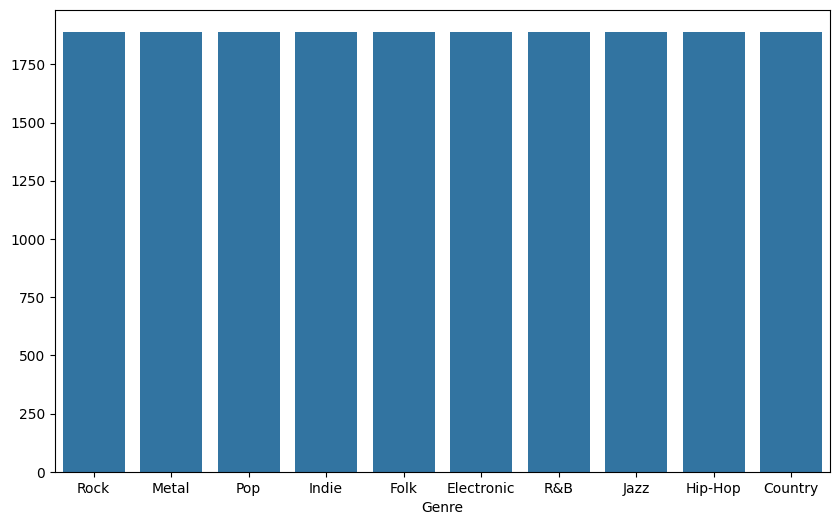

In [111]:
ds_cleaned_en_training_data = downsample_data(cleaned_en_training_data, 'Genre')

# Plot distribution of random down sampled data
en_genre_counts = ds_cleaned_en_training_data['Genre'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=en_genre_counts.index, y=en_genre_counts.values)

In [112]:
# Removed non-English lyrics
# Removed URLs
# Removed HTML tags
# Removed special characters and numbers
# Replaced multiple spaces with a single space
# Lowercased
# Removed stop words
# Random Oversampling by genre

# Check distribution in the original data
original_distribution = training_data['Genre'].value_counts(normalize=True)

# Check distribution in the cleaned sample
cleaned_distribution = cleaned_en_training_data['Genre'].value_counts(normalize=True)

# Check distribution in the down sampled data
ds_distribution = ds_cleaned_en_training_data['Genre'].value_counts(normalize=True)

print("Original:\n", original_distribution)
print("Cleaned:\n", cleaned_distribution)
print("Downsampled:\n", ds_distribution)

Original:
 Genre
Rock          0.418370
Pop           0.374639
Metal         0.069925
Jazz          0.046677
Folk          0.029788
Indie         0.029116
R&B           0.009625
Hip-Hop       0.007719
Electronic    0.007626
Country       0.006513
Name: proportion, dtype: float64
Cleaned:
 Genre
Rock          0.428243
Pop           0.344920
Metal         0.076472
Jazz          0.053214
Folk          0.032650
Indie         0.028937
R&B           0.011051
Hip-Hop       0.008945
Electronic    0.008014
Country       0.007554
Name: proportion, dtype: float64
Downsampled:
 Genre
Rock          0.1
Metal         0.1
Pop           0.1
Indie         0.1
Folk          0.1
Electronic    0.1
R&B           0.1
Jazz          0.1
Hip-Hop       0.1
Country       0.1
Name: proportion, dtype: float64


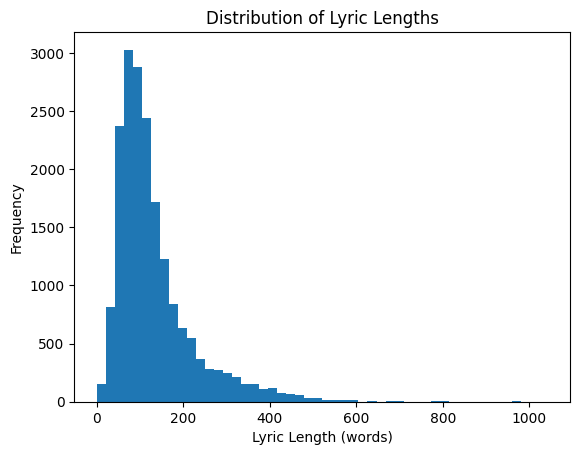

[ 73.  107.  159.  251.1 327. ]


In [113]:
lyric_lengths = [len(lyrics.split()) for lyrics in ds_cleaned_en_training_data['Lyrics']]
plt.hist(lyric_lengths, bins=50)
plt.xlabel('Lyric Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Lyric Lengths')
plt.show()

# Calculate percentiles
print(np.percentile(lyric_lengths, [25, 50, 75, 90, 95]))

In [68]:
def prepare_training_data(training_data, num_words=15000, oov_token='<OOV>', maxlen=250, test_size=0.2, random_state=42):
    # Extract lyrics and genres
    lyrics = training_data['Lyrics']
    genres = training_data['Genre']

    # # Tokenize the lyrics
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(lyrics)  # Build vocabulary
    sequences = tokenizer.texts_to_sequences(lyrics)  # Convert lyrics to sequences of integers
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')  # Pad/truncate sequences

    # Encode the labels with LabelEncoder
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(genres)

    # Perform one-hot encoding
    one_hot_labels = to_categorical(encoded_labels)

    # Stratified split to maintain equal representation of genres
    X_train, X_val, y_train, y_val = train_test_split(
        padded_sequences,   # Use actual lyrics for baseline
        one_hot_labels,     # Use one-hot encoded labels
        test_size=test_size,
        random_state=random_state
    )

    return X_train, X_val, y_train, y_val, tokenizer, label_encoder



In [114]:
def prepare_training_data_with_artist(training_data, num_words=15000, oov_token='<OOV>', maxlen=250, test_size=0.2, random_state=42):
    # Extract lyrics, genres, and artists
    lyrics = training_data['Lyrics']
    genres = training_data['Genre']
    artists = training_data['Artist']

    # Tokenize the lyrics
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(lyrics)  # Build vocabulary
    sequences = tokenizer.texts_to_sequences(lyrics)  # Convert lyrics to sequences of integers
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')  # Pad/truncate sequences

    # One-hot encode the artist names
    artist_encoder = LabelEncoder()
    encoded_artists = artist_encoder.fit_transform(artists)  # Encode artist names to integers
    one_hot_artists = to_categorical(encoded_artists)  # One-hot encode the artist integers

    # Encode the genres with LabelEncoder
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(genres)
    one_hot_labels = to_categorical(encoded_labels)  # One-hot encode genre labels

    # Stratified split to maintain equal representation of genres
    X_train_lyrics, X_val_lyrics, X_train_artists, X_val_artists, y_train, y_val = train_test_split(
        padded_sequences,    # Use tokenized lyrics
        one_hot_artists,     # Use one-hot encoded artist labels
        one_hot_labels,      # Use one-hot encoded genre labels
        test_size=test_size,
        random_state=random_state,
        stratify=genres,
    )

    return X_train_lyrics, X_val_lyrics, X_train_artists, X_val_artists, y_train, y_val, tokenizer, label_encoder, artist_encoder

def prepare_training_data_raw_text(training_data, test_size=0.2, random_state=42):
    """
    Prepares the training and validation data for the LSTM model with the Universal Sentence Encoder.

    Parameters:
    - training_data (pd.DataFrame): DataFrame containing 'Lyrics', 'Genre', and 'Artist' columns.
    - test_size (float): Fraction of data to be used for validation.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - X_train_lyrics_raw: Training lyrics data (strings).
    - X_val_lyrics_raw: Validation lyrics data (strings).
    - X_train_artists_raw: One-hot encoded artist labels for training.
    - X_val_artists_raw: One-hot encoded artist labels for validation.
    - y_train_raw: One-hot encoded genre labels for training.
    - y_val_raw: One-hot encoded genre labels for validation.
    - label_encoder_raw: LabelEncoder object fitted on the genres.
    - artist_encoder_raw: LabelEncoder object fitted on the artists.
    """
    # Extract lyrics, genres, and artists
    lyrics = training_data['Lyrics']
    genres = training_data['Genre']
    artists = training_data['Artist']

    # One-hot encode the artist names
    artist_encoder_raw = LabelEncoder()
    encoded_artists = artist_encoder_raw.fit_transform(artists)  # Encode artist names to integers
    one_hot_artists = to_categorical(encoded_artists)  # One-hot encode the artist integers

    # Encode the genres with LabelEncoder
    label_encoder_raw = LabelEncoder()
    encoded_labels = label_encoder_raw.fit_transform(genres)
    one_hot_labels = to_categorical(encoded_labels)  # One-hot encode genre labels

    # Stratified split to maintain equal representation of genres
    X_train_lyrics_raw, X_val_lyrics_raw, y_train_raw, y_val_raw, X_train_artists_raw, X_val_artists_raw = train_test_split(
        lyrics,             # Raw text lyrics
        one_hot_labels,     # One-hot encoded genre labels
        one_hot_artists,    # One-hot encoded artist labels
        test_size=test_size,
        random_state=random_state,
        stratify=genres,    # Stratify by genre to maintain class distribution
    )

    # Convert lyrics to strings if not already
    X_train_lyrics_raw = np.array(X_train_lyrics_raw).astype(str)
    X_val_lyrics_raw = np.array(X_val_lyrics_raw).astype(str)

    return X_train_lyrics_raw, X_val_lyrics_raw, X_train_artists_raw, X_val_artists_raw, y_train_raw, y_val_raw, label_encoder_raw, artist_encoder_raw

In [77]:
# Prepare training data
X_train, X_val, y_train, y_val, tokenizer, label_encoder = prepare_training_data(ds_cleaned_en_training_data)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1720, 250), (430, 250), (1720, 10), (430, 10))

In [115]:
X_train_lyrics, X_val_lyrics, X_train_artists, X_val_artists, y_train, y_val, tokenizer, label_encoder, artist_encoder = prepare_training_data_with_artist(ds_cleaned_en_training_data)
X_train_lyrics.shape, X_val_lyrics.shape, X_train_artists.shape, X_val_artists.shape, y_train.shape, y_val.shape

((15120, 250),
 (3780, 250),
 (15120, 4495),
 (3780, 4495),
 (15120, 10),
 (3780, 10))

In [116]:
# Access the vocabulary
vocabulary = tokenizer.word_index

# Print the vocabulary (optional)
print("Vocabulary Size:", len(tokenizer.word_index) + 1)

Vocabulary Size: 61770


In [117]:
oov_words = 0
total_words = 0

for lyrics in ds_cleaned_en_training_data['Lyrics']:
    words = lyrics.split()  # Tokenize lyrics into words
    total_words += len(words)

    sequence = tokenizer.texts_to_sequences([lyrics])[0]  # Get sequence for lyrics

    for word_index in sequence:
        if word_index == tokenizer.word_index[tokenizer.oov_token]:  # Check for OOV token index
            oov_words += 1

oov_rate = (oov_words / total_words) * 100

print(f"OOV Rate: {oov_rate:.2f}%")

OOV Rate: 3.54%


## Simple RNN

### Create Simple RNN

In [78]:
# Create the RNN model
simple_rnn_model = Sequential([
  Embedding(input_dim=15000, output_dim=512),
  SimpleRNN(512),
  Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
  Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
simple_rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

simple_rnn_model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the Simple RNN model

In [79]:
# Train the model
checkpoint_dir = 'model_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'simple_rnn_best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

simple_rnn_history = simple_rnn_model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=20,
  batch_size=64,
  callbacks=callbacks,
  verbose=1
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.1120 - loss: 4.2456
Epoch 1: val_accuracy improved from -inf to 0.13721, saving model to model_checkpoints/simple_rnn_best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 342ms/step - accuracy: 0.1123 - loss: 4.2420 - val_accuracy: 0.1372 - val_loss: 3.9167
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1461 - loss: 3.8718
Epoch 2: val_accuracy did not improve from 0.13721
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1457 - loss: 3.8718 - val_accuracy: 0.1326 - val_loss: 3.7632
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1318 - loss: 3.7288
Epoch 3: val_accuracy improved from 0.13721 to 0.16744, saving model to model_checkpoints/simple_rnn_best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.1324 - loss: 3.7261 - val_accuracy: 0.1674 - val_loss: 3.5778
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1606 - loss: 3.5083
Epoch 4: val_accuracy imp

## Single Layer LSTM

### Create Single Layer LSTM

In [80]:
# Create the LSTM model
lstm_model = Sequential([
  Embedding(input_dim=15000, output_dim=512),  # Same input dimension and output dimension as the RNN model
  LSTM(512),
  Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
  Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the LSTM model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
lstm_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train Single Layer LSTM

In [81]:
# Train the LSTM model
lstm_checkpoint_dir = 'lstm_model_checkpoints'
if not os.path.exists(lstm_checkpoint_dir):
  os.makedirs(lstm_checkpoint_dir)

lstm_callbacks = [
  EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
  ),
  ModelCheckpoint(
    filepath=os.path.join(lstm_checkpoint_dir, 'lstm_best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
  )
]

lstm_history = lstm_model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=64,
  callbacks=lstm_callbacks,
  verbose=1
)

Epoch 1/50
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1225 - loss: 4.0233
Epoch 1: val_accuracy improved from -inf to 0.18605, saving model to lstm_model_checkpoints/lstm_best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.1238 - loss: 4.0032 - val_accuracy: 0.1860 - val_loss: 3.2057
Epoch 2/50
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1542 - loss: 3.0749
Epoch 2: val_accuracy did not improve from 0.18605
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1543 - loss: 3.0600 - val_accuracy: 0.1837 - val_loss: 2.6807
Epoch 3/50
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1627 - loss: 2.6561
Epoch 3: val_accuracy did not improve from 0.18605
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1629 - loss: 2.6474 - val_accuracy: 0.1744 - val_loss: 2.4443
Epoch 4/50
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1566 - loss: 2.4589
Epoch 4: val_accuracy did not improve from 0.18605
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - acc

### Single Layer LSTM with Artist

In [120]:
# Define model architecture
def build_model(vocab_size, artist_input_dim, embedding_dim=128, lstm_units=64, num_classes=10):
    # Lyrics input
    lyrics_input = Input(shape=(None,), name="Lyrics_Input")
    lyrics_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="Lyrics_Embedding")(lyrics_input)
    lyrics_lstm = LSTM(units=lstm_units, return_sequences=False,
                       kernel_regularizer=l2(0.001), name="Lyrics_LSTM")(lyrics_embedding)
    lyrics_dropout = Dropout(0.5, name="Lyrics_Dropout")(lyrics_lstm)  # Dropout for lyrics

    # Artist input
    artist_input = Input(shape=(artist_input_dim,), name="Artist_Input")
    artist_dense = Dense(units=32, activation='relu', kernel_regularizer=l2(0.001), name="Artist_Dense")(artist_input)
    artist_dropout = Dropout(0.5, name="Artist_Dropout")(artist_dense)  # Dropout for artist

    # Combine features
    combined = concatenate([lyrics_dropout, artist_dropout], name="Concatenate_Layer")
    dense1 = Dense(units=64, activation='relu', kernel_regularizer=l2(0.001), name="Dense1")(combined)
    dense1_bn = BatchNormalization(name="BatchNorm1")(dense1)  # Batch normalization
    dense1_dropout = Dropout(0.5, name="Dense1_Dropout")(dense1_bn)
    output = Dense(units=num_classes, activation='softmax', name="Output")(dense1_dropout)

    # Build model
    model = Model(inputs=[lyrics_input, artist_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the model
vocab_size = 15000 + 1  # Adjusted for tokenizer
artist_input_dim = X_train_artists.shape[1]  # Number of artist features (one-hot encoded)
num_classes = y_train.shape[1]  # Number of genre classes
lstm_with_artist_model = build_model(vocab_size, artist_input_dim, num_classes=num_classes)

# Prepare for training
checkpoint_dir = 'model_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'multi_input_best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.argmax(axis=1)),  # Get original class labels from one-hot encoding
    y=y_train.argmax(axis=1)  # Convert one-hot to class indices
)
class_weights = dict(enumerate(class_weights))

# Pass class weights to model.fit
lstm_with_artist_history = lstm_with_artist_model.fit(
    [X_train_lyrics, X_train_artists], y_train,
    validation_data=([X_val_lyrics, X_val_artists], y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weights
)


Epoch 1/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1762 - loss: 2.4327
Epoch 1: val_accuracy improved from -inf to 0.47566, saving model to model_checkpoints/multi_input_best_model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1765 - loss: 2.4318 - val_accuracy: 0.4757 - val_loss: 2.2494
Epoch 2/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5698 - loss: 1.4163
Epoch 2: val_accuracy improved from 0.47566 to 0.84735, saving model to model_checkpoints/multi_input_best_model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5700 - loss: 1.4156 - val_accuracy: 0.8474 - val_loss: 1.1649
Epoch 3/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8046 - loss: 0.7626
Epoch 3: val_accuracy improved from 0.84735 to 0.86270, saving model to model_checkpoints/multi_input_best_model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8047 - loss: 0.7624 - val_accuracy: 0.8627 - val_loss: 0.5916
Epoch 4/20
236/237 ━━━━━━━━━━━━

## Multi-Layer LSTM

### Create Multi-Layer LSTM

In [82]:
multi_lstm_model = Sequential([
    Embedding(input_dim=15000, output_dim=512),
    Bidirectional(LSTM(512, return_sequences=True)),  # Bi-directional for capturing both forward and backward context
    Dropout(0.3),
    LSTM(512),  # Adding a second LSTM layer for more feature extraction
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(10, activation='softmax')  # Output layer with 10 classes
])

# Compile the multi-layer LSTM model
multi_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
multi_lstm_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train Multi-Layer LSTM


#### Multi Layer Lyrics Only

In [83]:
multi_lstm_checkpoint_dir = 'multi_lstm_model_checkpoints'
if not os.path.exists(multi_lstm_checkpoint_dir):
  os.makedirs(multi_lstm_checkpoint_dir)

multi_lstm_callbacks = [
  EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
  ),
  ModelCheckpoint(
    filepath=os.path.join(multi_lstm_checkpoint_dir, 'multi_lstm_best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
  )
]

multi_lstm_history = multi_lstm_model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=64,
  callbacks=multi_lstm_callbacks,
  verbose=1
)

Epoch 1/50
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1218 - loss: 4.0394
Epoch 1: val_accuracy improved from -inf to 0.17209, saving model to multi_lstm_model_checkpoints/multi_lstm_best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.1232 - loss: 4.0196 - val_accuracy: 0.1721 - val_loss: 3.2529
Epoch 2/50
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1672 - loss: 3.0996
Epoch 2: val_accuracy did not improve from 0.17209
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.1667 - loss: 3.0916 - val_accuracy: 0.1651 - val_loss: 2.6926
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1441 - loss: 2.6558
Epoch 3: val_accuracy improved from 0.17209 to 0.17442, saving model to multi_lstm_model_checkpoints/multi_lstm_best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.1444 - loss: 2.6536 - val_accuracy: 0.1744 - val_loss: 2.4571
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1682 - loss: 2.4096
Epoch 

#### Multi Layer with Artist

In [121]:
# Define model architecture
def build_model(vocab_size, artist_input_dim, embedding_dim=128, lstm_units=64, num_classes=10):
    # Lyrics input
    lyrics_input = Input(shape=(None,), name="Lyrics_Input")
    lyrics_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="Lyrics_Embedding")(lyrics_input)

    # Add multiple LSTM layers
    lyrics_lstm1 = LSTM(units=lstm_units, return_sequences=True,
                        kernel_regularizer=l2(0.001), name="Lyrics_LSTM1")(lyrics_embedding)
    lyrics_lstm2 = LSTM(units=lstm_units, return_sequences=False,
                        kernel_regularizer=l2(0.001), name="Lyrics_LSTM2")(lyrics_lstm1)
    lyrics_dropout = Dropout(0.5, name="Lyrics_Dropout")(lyrics_lstm2)  # Dropout for lyrics

    # Artist input
    artist_input = Input(shape=(artist_input_dim,), name="Artist_Input")
    artist_dense = Dense(units=32, activation='relu', kernel_regularizer=l2(0.001), name="Artist_Dense")(artist_input)
    artist_dropout = Dropout(0.5, name="Artist_Dropout")(artist_dense)  # Dropout for artist

    # Combine features
    combined = concatenate([lyrics_dropout, artist_dropout], name="Concatenate_Layer")
    dense1 = Dense(units=64, activation='relu', kernel_regularizer=l2(0.001), name="Dense1")(combined)
    dense1_bn = BatchNormalization(name="BatchNorm1")(dense1)  # Batch normalization
    dense1_dropout = Dropout(0.5, name="Dense1_Dropout")(dense1_bn)
    output = Dense(units=num_classes, activation='softmax', name="Output")(dense1_dropout)

    # Build model
    model = Model(inputs=[lyrics_input, artist_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the model
vocab_size = 15000 + 1  # Adjusted for tokenizer
artist_input_dim = X_train_artists.shape[1]  # Number of artist features (one-hot encoded)
num_classes = y_train.shape[1]  # Number of genre classes
multi_lstm_with_artist_model = build_model(vocab_size, artist_input_dim, num_classes=num_classes)

# Prepare for training
checkpoint_dir = 'model_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'multi_input_best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.argmax(axis=1)),  # Get original class labels from one-hot encoding
    y=y_train.argmax(axis=1)  # Convert one-hot to class indices
)
class_weights = dict(enumerate(class_weights))

# Pass class weights to model.fit
multi_lstm_with_artist_history = multi_lstm_with_artist_model.fit(
    [X_train_lyrics, X_train_artists], y_train,
    validation_data=([X_val_lyrics, X_val_artists], y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weights
)



Epoch 1/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1901 - loss: 2.4520
Epoch 1: val_accuracy improved from -inf to 0.57169, saving model to model_checkpoints/multi_input_best_model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.1906 - loss: 2.4508 - val_accuracy: 0.5717 - val_loss: 2.2262
Epoch 2/20
235/237 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6122 - loss: 1.3070
Epoch 2: val_accuracy improved from 0.57169 to 0.84709, saving model to model_checkpoints/multi_input_best_model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6128 - loss: 1.3053 - val_accuracy: 0.8471 - val_loss: 1.1466
Epoch 3/20
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8078 - loss: 0.7592
Epoch 3: val_accuracy improved from 0.84709 to 0.86614, saving model to model_checkpoints/multi_input_best_model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8079 - loss: 0.7590 - val_accuracy: 0.8661 - val_loss: 0.5912
Epoch 4/20
237/237 ━━━━━━━━━━━━

## Compare Models

248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Simple RNN Accuracy: 0.15173283219337463
Simple RNN Classification Report:
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       810
  Electronic       0.11      0.02      0.03       660
        Folk       0.00      0.00      0.00       495
     Hip-Hop       0.30      0.86      0.45       960
       Indie       0.07      0.70      0.13       510
        Jazz       0.00      0.00      0.00       660
       Metal       0.00      0.00      0.00       810
         Pop       0.14      0.01      0.02      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.00      0.00      0.00      1410

    accuracy                           0.15      7935
   macro avg       0.06      0.16      0.06      7935
weighted avg       0.07      0.15      0.07      7935



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Single Layer LSTM Accuracy: 0.1643352210521698
Single Layer LSTM Classification Report:
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.00      0.00      0.00       495
     Hip-Hop       0.20      0.93      0.33       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.00      0.00      0.00       660
       Metal       0.00      0.00      0.00       810
         Pop       0.12      0.37      0.18      1110
         R&B       0.00      0.00      0.00       510
        Rock       0.00      0.00      0.00      1410

    accuracy                           0.16      7935
   macro avg       0.03      0.13      0.05      7935
weighted avg       0.04      0.16      0.07      7935



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Multi-Layer LSTM Accuracy: 0.14984247088432312
Multi-Layer LSTM Classification Report:
              precision    recall  f1-score   support

     Country       0.10      0.05      0.06       810
  Electronic       0.00      0.00      0.00       660
        Folk       0.06      0.11      0.08       495
     Hip-Hop       0.20      0.93      0.33       960
       Indie       0.00      0.00      0.00       510
        Jazz       0.00      0.00      0.00       660
       Metal       0.12      0.15      0.13       810
         Pop       0.17      0.02      0.04      1110
         R&B       0.06      0.12      0.08       510
        Rock       0.00      0.00      0.00      1410

    accuracy                           0.15      7935
   macro avg       0.07      0.14      0.07      7935
weighted avg       0.08      0.15      0.08      7935



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Single Layer LSTM with Artist Accuracy: 0.30270951986312866
Single Layer LSTM with Artist Classification Report:
              precision    recall  f1-score   support

     Country       0.91      0.01      0.02       810
  Electronic       1.00      0.34      0.51       660
        Folk       0.90      0.16      0.28       495
     Hip-Hop       0.88      0.32      0.46       960
       Indie       0.86      0.12      0.20       510
        Jazz       0.70      0.01      0.02       660
       Metal       0.91      0.22      0.36       810
         Pop       0.73      0.08      0.15      1110
         R&B       0.94      0.20      0.33       510
        Rock       0.20      0.95      0.33      1410

    accuracy                           0.30      7935
   macro avg       0.80      0.24      0.27      7935
weighted avg       0.74      0.30      0.27      7935

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Multi-Layer LSTM with Artist Accuracy: 0.30422

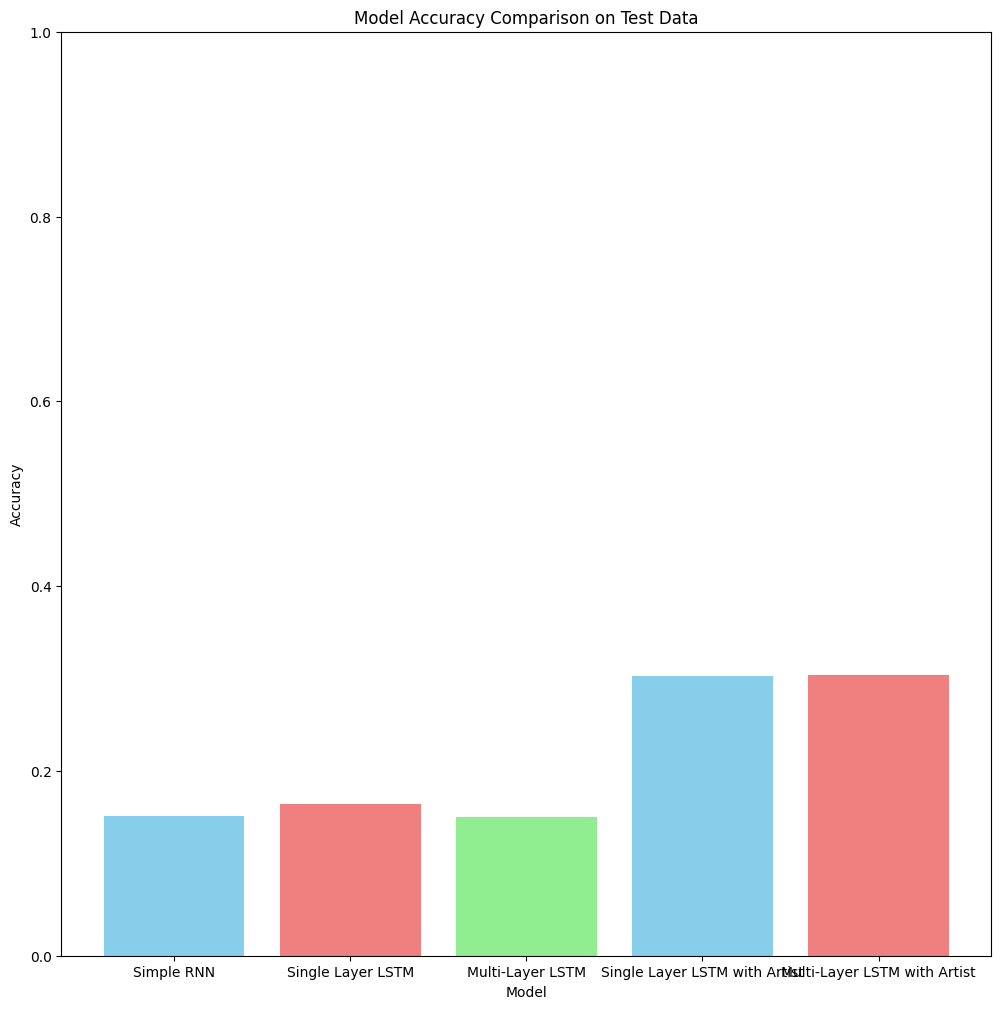

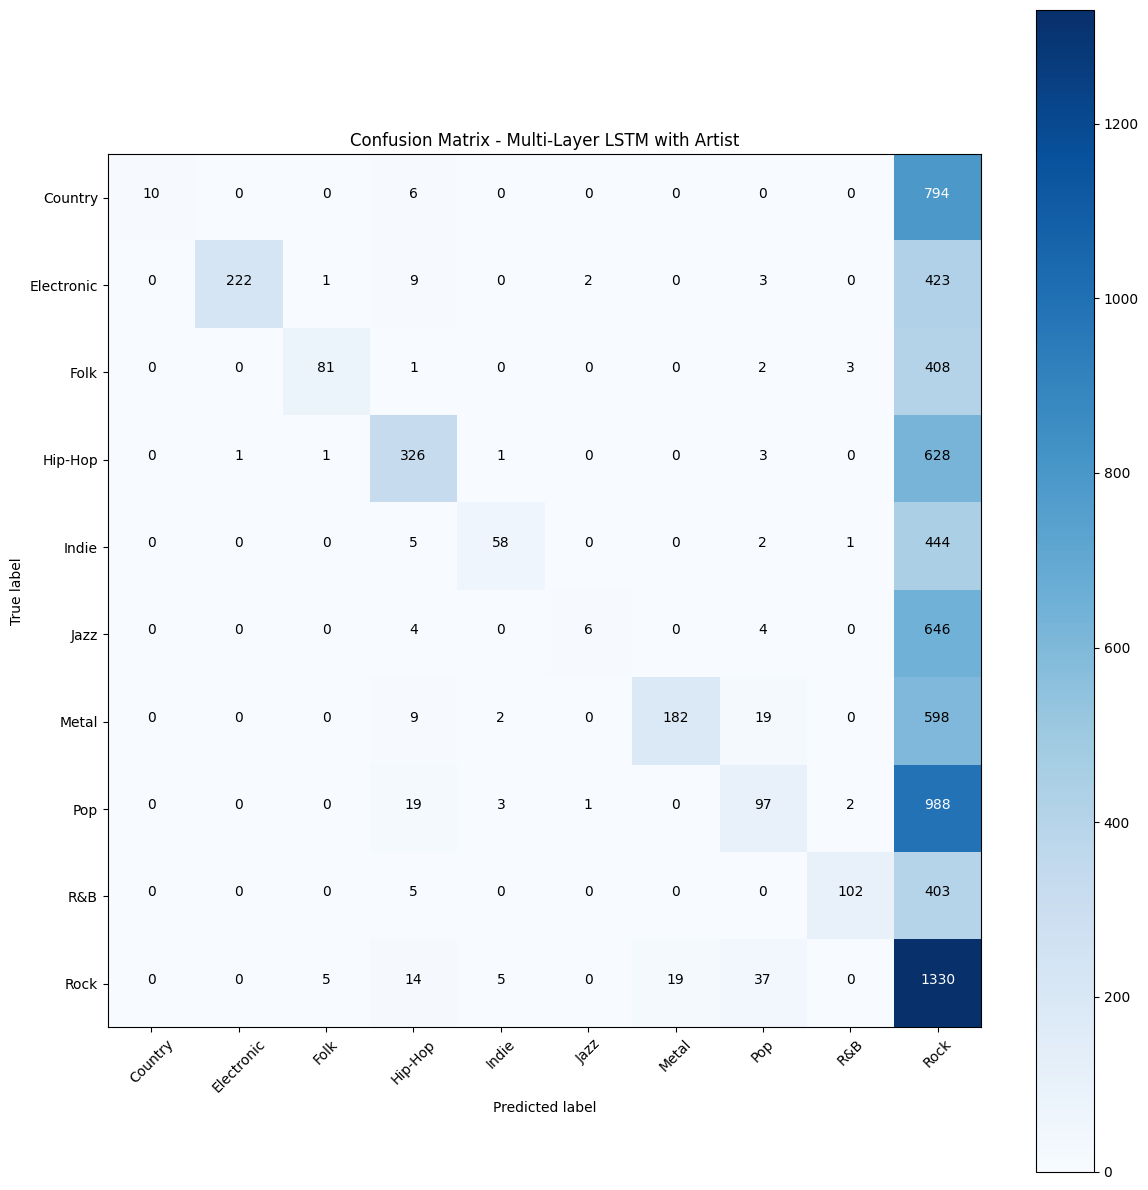

In [123]:
# Load the test data
test_data_path = os.path.join(data_dir, 'test.csv')
test_data = pd.read_csv(test_data_path)

# Preprocess the test data using the same tokenizer and label encoder
lyrics_test = test_data['Lyrics'].astype(str).values
genres_test = test_data['Genre'].values
artists_test = test_data['Artist'].values # Get artist data for test set

sequences_test = tokenizer.texts_to_sequences(lyrics_test)
padded_sequences_test = pad_sequences(sequences_test, maxlen=250, padding='post', truncating='post')

# **Change 1: Encode labels as multiclass**
encoded_labels_test = label_encoder.transform(genres_test)

# Prepare artist data for the test set
# Instead of directly using transform, handle unknown artists:
encoded_artists_test = np.array([artist_encoder.transform([artist])[0] if artist in artist_encoder.classes_ else -1 for artist in artists_test])

# Create a new encoder with the unknown class
# new_artist_encoder = LabelEncoder()  # No need to create a new encoder
# new_artist_encoder.classes_ = np.append(artist_encoder.classes_, '<UNK>')  # Add <UNK> class

# Re-encode the artists, replacing unknown artists with the <UNK> class label
# encoded_artists_test = np.where(encoded_artists_test == -1, new_artist_encoder.transform(['<UNK>'])[0], encoded_artists_test)

# One-hot encode artist data with the new encoder, ensure consistent dimensions
#  Adjusting one-hot encoding for artist features to align with the model's input expectations
num_artist_features = artist_input_dim #artist_encoder.classes_.shape[0] # Use artist_input_dim for consistency
one_hot_artists_test = to_categorical(encoded_artists_test, num_classes=num_artist_features)
one_hot_artists_test = one_hot_artists_test[:, :artist_input_dim]  # Select the relevant columns

# Evaluate each model
models = {
    'Simple RNN': simple_rnn_model,
    'Single Layer LSTM': lstm_model,
    'Multi-Layer LSTM': multi_lstm_model,
    'Single Layer LSTM with Artist': lstm_with_artist_model,
    'Multi-Layer LSTM with Artist': multi_lstm_with_artist_model,
}

results = {}
for model_name, model in models.items():
  if model_name in ['Single Layer LSTM with Artist', 'Multi-Layer LSTM with Artist']: # Models requiring artist input
    _, accuracy = model.evaluate([padded_sequences_test, one_hot_artists_test], to_categorical(encoded_labels_test, num_classes=len(label_encoder.classes_)), verbose=0)
    y_pred = np.argmax(model.predict([padded_sequences_test, one_hot_artists_test]), axis=1)
  else:
    _, accuracy = model.evaluate(padded_sequences_test, to_categorical(encoded_labels_test, num_classes=len(label_encoder.classes_)), verbose=0)
    y_pred = np.argmax(model.predict(padded_sequences_test), axis=1)

  results[model_name] = {
      'Accuracy': accuracy,
      'Classification Report': classification_report(encoded_labels_test, y_pred, target_names=label_encoder.classes_),
      'Confusion Matrix': confusion_matrix(encoded_labels_test, y_pred)
  }
  print(f"{model_name} Accuracy: {accuracy}")
  print(f"{model_name} Classification Report:\n{results[model_name]['Classification Report']}")

# Visualize the results
accuracy_scores = [results[model_name]['Accuracy'] for model_name in models]
model_names = list(models.keys())

plt.figure(figsize=(12, 12))
plt.bar(model_names, accuracy_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Model Accuracy Comparison on Test Data')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


# Example: Visualizing Confusion Matrix for the best-performing model
# You can adapt this to visualize confusion matrix for other models too.
best_model_name = max(results, key=lambda k: results[k]['Accuracy'])
cm = results[best_model_name]['Confusion Matrix']

plt.figure(figsize=(12, 12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
  plt.text(j, i, format(cm[i, j], 'd'),
           horizontalalignment="center",
           color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

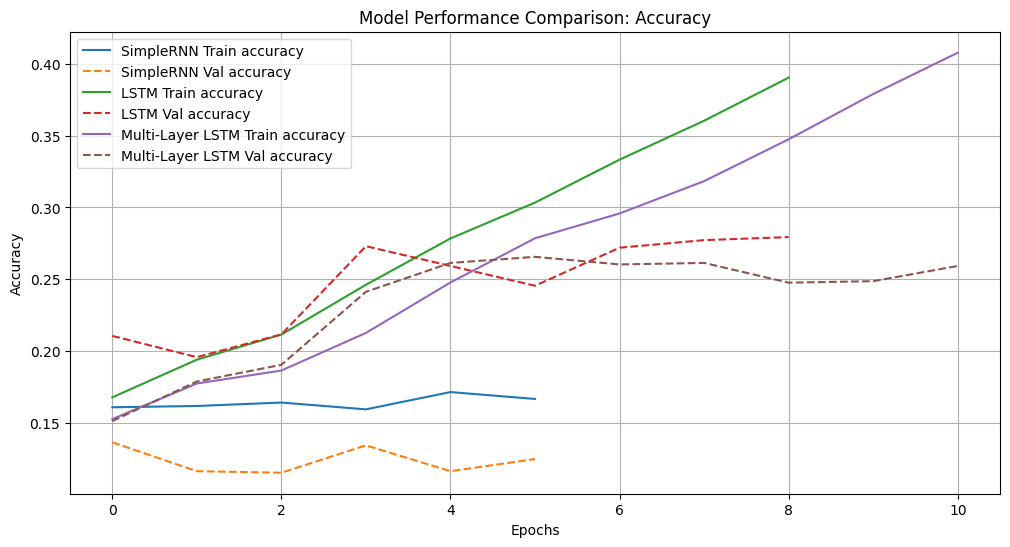

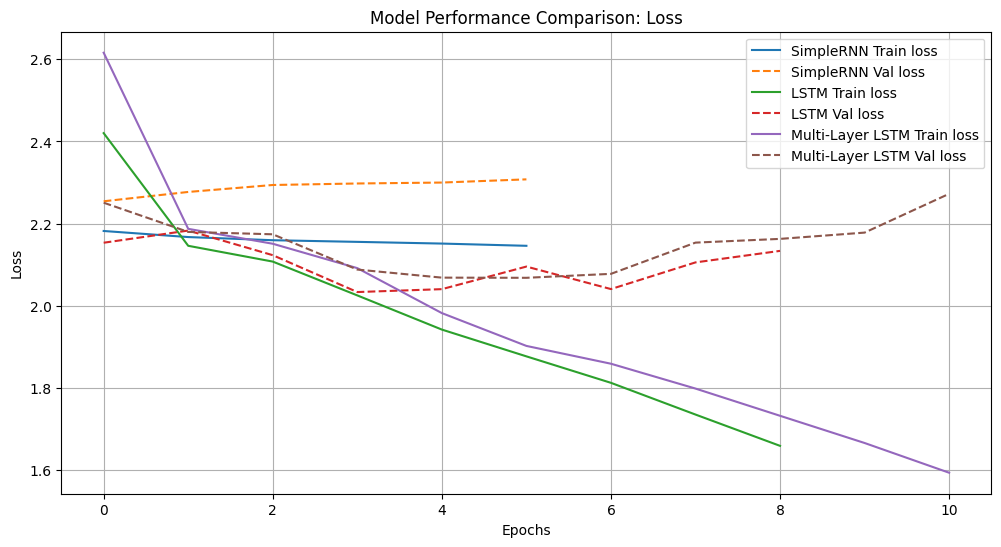

In [228]:
def plot_model_performance_direct(histories, model_names, metric="accuracy"):
    plt.figure(figsize=(12, 6))

    for history, model_name in zip(histories, model_names):
        # Access metrics using dot notation (.) instead of square brackets ([])
        plt.plot(history.history[metric], label=f'{model_name} Train {metric}')
        plt.plot(history.history[f'val_{metric}'], linestyle='--', label=f'{model_name} Val {metric}')

    plt.title(f'Model Performance Comparison: {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualizing performance with the adjusted function
plot_model_performance_direct(
    histories=[history, lstm_history, multi_lstm_history],
    model_names=["SimpleRNN", "LSTM", "Multi-Layer LSTM"],
    metric="accuracy"
)

plot_model_performance_direct(
    histories=[history, lstm_history, multi_lstm_history],
    model_names=["SimpleRNN", "LSTM", "Multi-Layer LSTM"],
    metric="loss"
)
